In [1]:
import numpy as np
from itertools import permutations

from astropy import units as u
from astropy.coordinates import SkyCoord, Distance
from astropy.table import Table
from astropy import modeling

%matplotlib inline
from matplotlib import rcParams
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from astropy.visualization import hist as ahist

PM expectations from http://arxiv.org/abs/0805.2366, Table 3, pg 22 (in v4)

In [2]:
lsst_expected = Table()

t_survey = 10*u.yr # this is the baseline for the numbers in the LSST dcoument


lsst_expected['r'] = [21, 22 ,23, 24]*u.mag
lsst_expected['r'].description = 'magnitude of target'

lsst_expected['sig_xy'] = [11, 15, 31, 74]*u.mas
lsst_expected['sig_xy'].description = 'Typical astrometric accuracy (rms per coordinate per visit)'

_parr_t_scale = (t_survey/(10*u.yr)).decompose()**(-1/2)
lsst_expected['sig_pi'] = [0.6, 0.8, 1.3, 2.9]*u.mas*_parr_t_scale
lsst_expected['sig_pi'].description = 'Parallax accuracy for 10 year long survey'

_pm_t_scale = (t_survey/(10*u.yr)).decompose()**(-3/2)
lsst_expected['sig_mu'] = [0.2, 0.3, 0.5, 1.]*u.mas/u.yr*_pm_t_scale
lsst_expected['sig_mu'].description = 'Proper motion accuracy for 10 year long survey'

lsst_expected['sig_1'] = [0.01, 0.02, 0.04, 0.1]*u.mag
lsst_expected['sig_1'].description = 'Photometric error for single visit'

lsst_expected['sig_C'] = [0.005, 0.005, 0.006, 0.009]*u.mag
lsst_expected['sig_C'].description = 'Photometric error for coadded observations'

# First a model for mapping from point-source PMs to bulk PMs 

<PowerLaw1D(amplitude=0.15497442638492737, x_0=21.0, alpha=-13.836555526351784)>

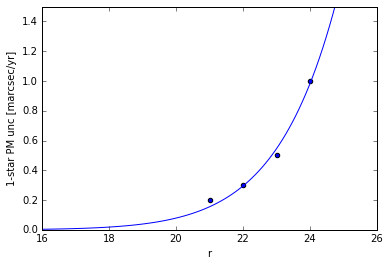

In [3]:
pl = modeling.models.PowerLaw1D(x_0=21, amplitude=.2, alpha=-15)
pl.x_0.fixed = True
pl = modeling.fitting.LevMarLSQFitter()(pl, lsst_expected['r'], lsst_expected['sig_mu'])


xs = np.linspace(16,26,100)
plt.scatter(lsst_expected['r'], lsst_expected['sig_mu'])
plt.plot(xs, pl(xs))
plt.xlim(xs[0], xs[-1])
plt.ylim(0,np.max(lsst_expected['sig_mu'])*1.5)
plt.xlabel('r')
plt.ylabel('1-star PM unc [marcsec/yr]')
pl

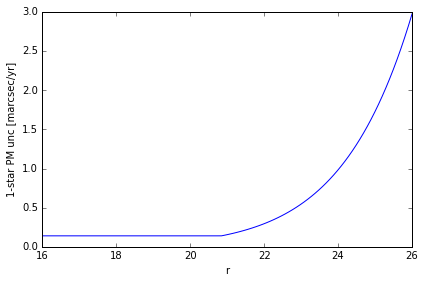

In [4]:
def pm_from_nstars(rmags, distance=None, sys_floor=0.14*u.mas/u.yr):
    """
    Parameters
    ----------
    rmags : astropy Quantity with magnitude units
        The magnitude(s) of the objects to compute the PM accuracy of
    distance : None or astropy Quantity with distance units
        The distance to assume the stars are at, or None to get angular units.
    sys_floor :  astropy Quantity with PM units (angle/time)
        The minimal PM accuracy possible - the "systematic floor". Default value 
        based on LSST science book.
        
    Returns
    -------
    bulk_pm : Quantity
        The PM uncertainty from averaging *all* the stars with the given `rmags`.
        Has PM units if `distance` is None or velocity units, otherwise.
    individual_pms : Quantity
        The PM uncertainty for each of the stars individually.
        Has PM units if `distance` is None or velocity units, otherwise.
    """
    pm_errs = pl(rmags.to(lsst_expected['r'].unit).value)*lsst_expected['sig_mu'].unit
    pm_errs[pm_errs<sys_floor] = sys_floor
    
    if distance is not None:
        pm_errs = (pm_errs*distance).to(u.km/u.s, u.dimensionless_angles())
    
    return np.sum(pm_errs**2)**0.5 * pm_errs.size**-1, pm_errs

xs = np.linspace(16,26,100)
plt.plot(xs,  pm_from_nstars(xs*u.mag)[-1])
plt.xlabel('r')
plt.ylabel('1-star PM unc [marcsec/yr]')
plt.tight_layout()

In [5]:
pmtab = Table()
pmtab['r_mag'] = mags = [17,18,19,20,21,22,23,24,25]*u.mag
for d in [25*u.kpc,100*u.kpc,300*u.kpc,1*u.Mpc]:
    pmtab['1 star PM @ {0:.0f}'.format(d)] = pm_from_nstars(mags, d)[1]
pmtab.show_in_notebook()

r_mag,1 star PM @ 25 kpc,1 star PM @ 100 kpc,1 star PM @ 300 kpc,1 star PM @ 1 Mpc
mag,km / s,km / s,km / s,km / s
17.0,16.5916466222,66.3665864889,199.099759467,663.665864889
18.0,16.5916466222,66.3665864889,199.099759467,663.665864889
19.0,16.5916466222,66.3665864889,199.099759467,663.665864889
20.0,16.5916466222,66.3665864889,199.099759467,663.665864889
21.0,18.3662922719,73.4651690875,220.395507263,734.651690875
22.0,34.9596249317,139.838499727,419.51549918,1398.38499727
23.0,64.6671343953,258.668537581,776.005612744,2586.68537581
24.0,116.527998123,466.111992494,1398.33597748,4661.11992494
25.0,204.991264339,819.965057354,2459.89517206,8199.65057354


In [6]:
print('This table is limits with *no* systematic floor')

pmtab = Table()
pmtab['r_mag'] = mags = [17,18,19,20,21,22,23,24,25]*u.mag
for d in [25*u.kpc,100*u.kpc,300*u.kpc,1*u.Mpc]:
    pmtab['1 star PM @ {0:.0f}'.format(d)] = pm_from_nstars(mags, d, 0*u.mas/u.yr)[1]
pmtab.show_in_notebook()

This table is limits with *no* systematic floor


r_mag,1 star PM @ 25 kpc,1 star PM @ 100 kpc,1 star PM @ 300 kpc,1 star PM @ 1 Mpc
mag,km / s,km / s,km / s,km / s
17.0,0.986814732431,3.94725892972,11.8417767892,39.4725892972
18.0,2.17624867218,8.7049946887,26.1149840661,87.049946887
19.0,4.59839215659,18.3935686264,55.1807058791,183.935686264
20.0,9.35049447699,37.4019779079,112.205933724,374.019779079
21.0,18.3662922719,73.4651690875,220.395507263,734.651690875
22.0,34.9596249317,139.838499727,419.51549918,1398.38499727
23.0,64.6671343953,258.668537581,776.005612744,2586.68537581
24.0,116.527998123,466.111992494,1398.33597748,4661.11992494
25.0,204.991264339,819.965057354,2459.89517206,8199.65057354


# Now make a very simple model for the galaxy based on a pure-RGB 

In [7]:
def sample_lum_func(n, alpha, tip, bottom):
    """
    A simple power law luminosity function 
    """
    m1, m2 = tip/u.mag, bottom/u.mag
    P = np.random.rand(n)
    paren = np.exp(alpha*m2) - np.exp(alpha*m1)
    F = P*paren + np.exp(alpha*m1)
    return np.log(F)/alpha

def mag_to_lum(mag, zpt=0*u.mag):
    return 10**((mag-zpt)/u.mag/-2.5)
def lum_to_mag(lum, zpt=0*u.mag):
    return zpt-2.5*np.log10(lum)*u.mag

def sample_dwarfy(absmag, distance, rgb_height=5*u.mag, alpha=.3*np.log(10)):
    trgbI = -4*u.mag  # very rough
    rmI = (4.65 - 4.1)*u.mag # for the sun
    trgbr = trgbI + rmI
    
    dm = Distance(distance).distmod 
    max_mag = absmag + dm
    tip_mag = dm + trgbr
    
    bottom_mag = tip_mag + rgb_height
    max_lum = mag_to_lum(max_mag)
    
    mags = []*u.mag
    totlum = max_lum - 1
    n = 100
    while totlum < max_lum:
        #print('n=', n, 'totlum=', totlum)
        mags = np.concatenate((mags.value, sample_lum_func(n, alpha, tip_mag, bottom_mag).value))*u.mag
        totlum = np.sum(mag_to_lum(mags))
        n = max(n, max_lum/totlum)
        
    cumlum = np.cumsum(mag_to_lum(mags))
    if np.sum(cumlum<max_lum) < 1:
        magres = mags[np.argsort(mags)[-1:]] # picks the faintest one
    else:
        magres = mags[cumlum<max_lum]
    return magres, lum_to_mag(np.sum(mag_to_lum(magres)))

In [8]:
mags = [-3, -4, -6, -8, -10]*u.mag
dists = [25, 100, 300, 1000]*u.kpc

magdists = []
for mag in mags:
    for dist in dists:
        magdists.append((mag, dist))

# Use that to make sample RGB LFs

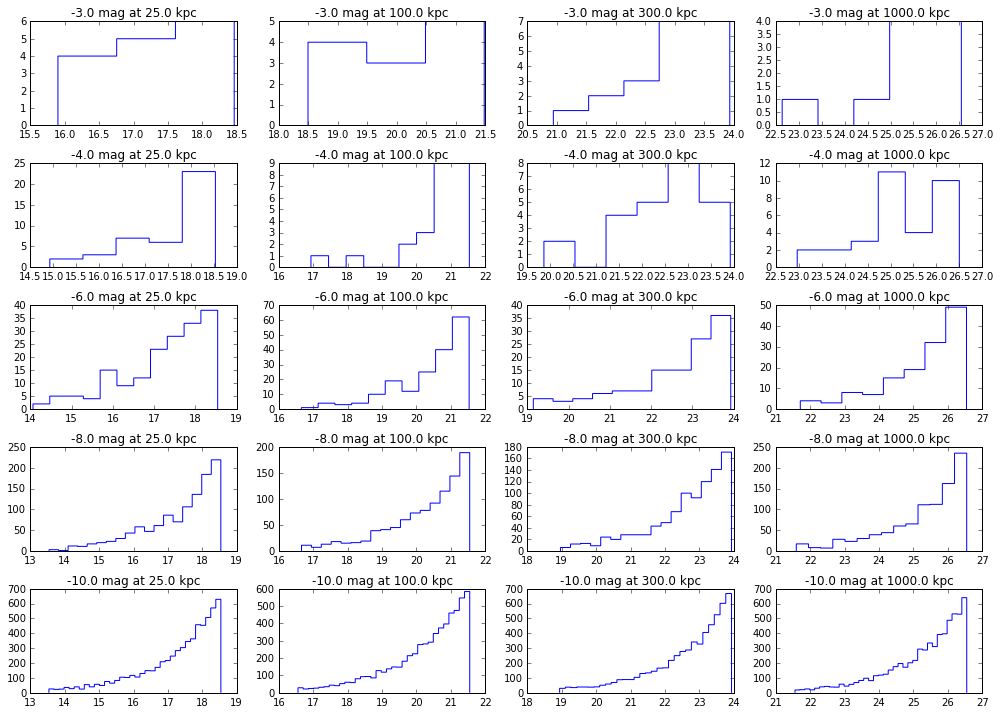

In [9]:
plt.figure(figsize=(14,10))
for i,(mag, dist) in enumerate(magdists):
    plt.subplot(len(mags),len(dists),i+1)
    ahist(sample_dwarfy(mag, dist)[0], bins='knuth', histtype='step')
    plt.title('{0} at {1}'.format(mag, dist))
plt.tight_layout()

# 1-star PM distributions for those LFs

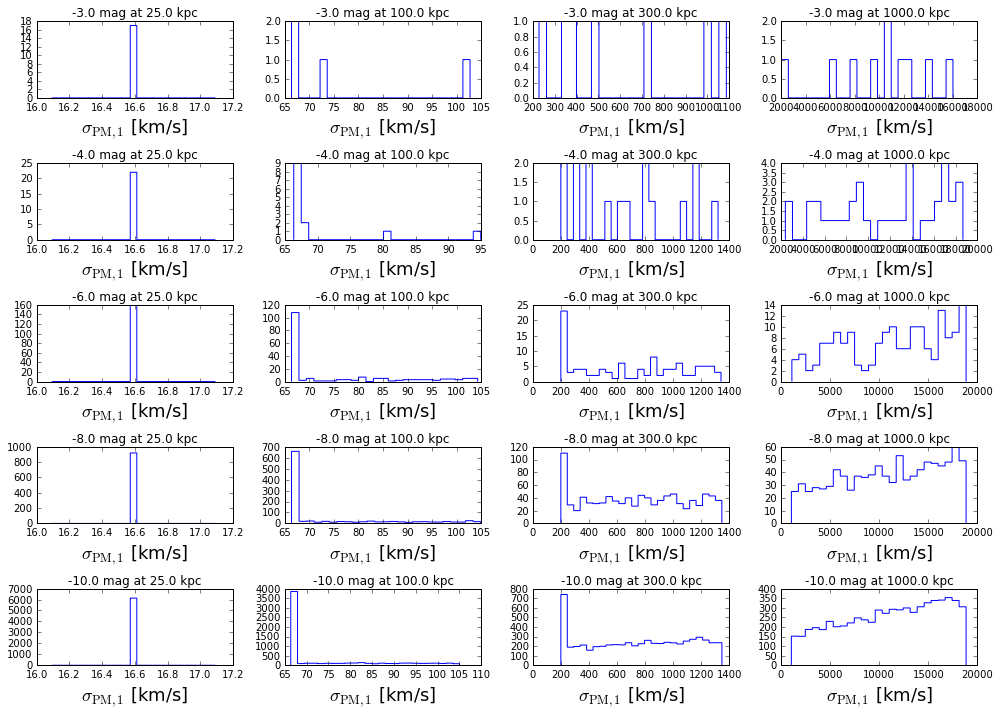

In [10]:
plt.figure(figsize=(14,10))
for i,(mag, dist) in enumerate(magdists):
    plt.subplot(len(mags),len(dists),i+1)
    dwarf_mags = sample_dwarfy(mag, dist)[0]
    pmerrs = pm_from_nstars(dwarf_mags, dist)[1]
    ahist(pmerrs.to(u.km/u.s), bins=25, histtype='step')
    plt.xlabel(r'$\sigma_{\rm PM, 1}$ [km/s]', fontsize=18)
    plt.title('{0} at {1}'.format(mag, dist))
plt.tight_layout()

# Bulk PMs for dwarfs with the above LFs 

/Users/erik/miniconda3/envs/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:6: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


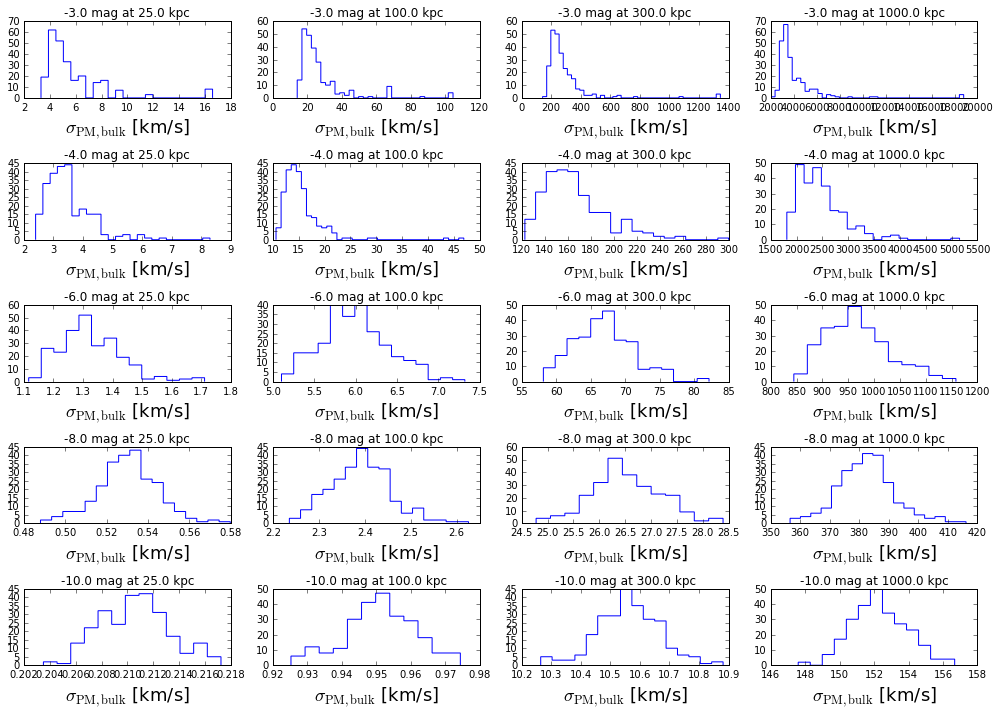

In [11]:
nsamples = 250

plt.figure(figsize=(14,10))
for i,(mag, dist) in enumerate(magdists):
    plt.subplot(len(mags),len(dists),i+1)
    mag_samples = [sample_dwarfy(mag, dist)[0] for _ in range(nsamples)]
    pms = u.Quantity([pm_from_nstars(s, dist)[0] for s in mag_samples])
    ahist(pms.to(u.km/u.s), bins='knuth', histtype='step')
    plt.xlabel(r'$\sigma_{\rm PM, bulk}$ [km/s]', fontsize=18)
    plt.title('{0} at {1}'.format(mag, dist))
plt.tight_layout()